# Preamble

In [1]:
from my_units import *

In [2]:
import rebound

In [4]:
from scipy import stats

In [5]:
import os, sys

import numpy as np
import pandas as pd
import scipy as sp

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad, nquad
from scipy.optimize import brentq

import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc

plt.rcdefaults()
fontsize = 14
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})

from tqdm import tqdm, tqdm_notebook
from time import time as tictoc

# Parameters

units of time: $\mathrm{year} = 2 \pi$;
units of distance: $\mathrm{AU} = 1$;
units of speed: $\sqrt{\frac{GM}{\mathrm{AU}}} = 1$

In [6]:
yr = 2*np.pi
AU = 1

## Planets

In [7]:
df_planets = pd.DataFrame(columns=['name','a','lambda','e','inc','omega','Omega','T','m/M'])

In [8]:
df_planets['name'] = ['Mercury','Venus','Earth','Mars','Jupiter','Saturn','Uranus','Neptune']
df_planets['a'] = [0.3871,0.7233,1.0000,1.5237,5.2025,9.5415,19.188,30.070] #in AU
df_planets['lambda'] = np.asarray([252.25,181.98,100.47,355.43,34.33,50.08,314.20,304.22])*degree
df_planets['e'] = [0.20564,0.00676,0.01673,0.09337,0.04854,0.05551,0.04686,0.00895]
df_planets['inc'] = np.asarray([7.006,3.398,0.000,1.852,1.299,2.494,0.773,1.770])*degree
df_planets['omega'] = np.asarray([77.46,131.77,102.93,336.08,14.27,92.86,172.43,46.68])*degree
df_planets['Omega'] = np.asarray([48.34,76.67,0.0,49.71,100.29,113.64,73.96,131.79])*degree
df_planets['T'] = np.asarray([0.241,0.615,1.000,1.881,11.87,29.47,84.05,164.9]) #in yr
df_planets['m/M'] = np.asarray([1.659e-7,2.447e-6,3.039e-6,3.226e-7,9.542e-4,2.857e-4,4.353e-5,5.165e-5]) #mass relative to M_sun

In [9]:
df_planets

,name,a,lambda,e,inc,omega,Omega,T,m/M
0,Mercury,0.3871,4.402593,0.20564,0.122278,1.351932,0.843692,0.241,1.659000e-07
1,Venus,0.7233,3.176150,0.00676,0.059306,2.299820,1.338144,0.615,2.447000e-06
2,Earth,1.0000,1.753532,0.01673,0.000000,1.796467,0.000000,1.000,3.039000e-06
3,Mars,1.5237,6.203424,0.09337,0.032323,5.865703,0.867603,1.881,3.226000e-07
4,Jupiter,5.2025,0.599172,0.04854,0.022672,0.249058,1.750391,11.870,9.542000e-04
5,Saturn,9.5415,0.874061,0.05551,0.043529,1.620713,1.983392,29.470,2.857000e-04
6,Uranus,19.1880,5.483825,0.04686,0.013491,3.009471,1.290846,84.050,4.353000e-05
7,Neptune,30.0700,5.309641,0.00895,0.030892,0.814720,2.300169,164.900,5.165000e-05


## Secular perturbations

In [10]:
e_il = np.transpose([
    [18128,629,404,66,0,0,0,0],
    [-2331,1919,1497,265,-1,-1,0,0],
    [154,-1262,1046,2979,0,0,0,0],
    [-169,1489,-1485,7281,0,0,0,0],
    [2446,1636,1634,1878,4331,3416,-4388,159],
    [10,-51,242,1562,-1560,4830,-180,-13],
    [59,58,62,82,207,189,2999,-322],
    [0,1,1,2,6,6,144,954]
]) * 1e-5

In [11]:
inc_il = np.transpose([
    [12548,1180,850,180,-2,-2,2,0],
    [-3548,1006,811,180,-1,-1,0,0],
    [409,-2684,2446,-3595,0,0,0,0],
    [116,-685,451,5021,0,-1,0,0],
    [2751,2751,2751,2751,2751,2751,2751,2751],
    [27,14,279,954,-636,1587,-69,-7],
    [-333,-191,-173,-125,-95,-77,1757,-206],
    [-144,-132,-129,-122,-116,-112,109,1181]
]) * 1e-5

In [12]:
g_l = np.asarray([5.462,7.346,17.33,18.00,3.724,22.44,2.708,0.6345]) * arcsec / yr
f_l = np.asarray([-5.201,-6.570,-18.74,-17.64,0.0,-25.90,-2.911,-0.6788]) * arcsec / yr

beta_l = np.asarray([89.65,195.0,336.1,319.0,30.12,131.0,109.9,67.98]) * degree
gamma_l = np.asarray([20.23,318.3,255.6,296.9,107.5,127.3,315.6,202.8]) * degree

# Functions

## Orbital elements

In [13]:
def fn_e(h,k):
    return np.sqrt(h**2 + k**2)
def fn_omega_bar(h,k):
    return np.mod(np.arctan2(h,k),2*np.pi)
def fn_inc(p,q):
    """Inclination as a function of osculating elements p,q. Returns value between [0,np.pi/2], i.e. does not discriminate between prograde and retrograde orbits."""
    return np.arcsin(np.sqrt(p**2 + q**2)) 
def fn_Omega(p,q):
    return np.mod(np.arctan2(p,q),2*np.pi)
def fn_omega(h,k,p,q):
    return np.mod(fn_omega_bar(h,k)-fn_Omega(p,q),2*np.pi)

## Secular perturbations

In [14]:
def fn_alpha(a,a_i):
    return np.min([a/a_i,a_i/a])
def fn_alpha_bar(a,a_i):
    return np.min([a/a_i,1])

In [15]:
def fn_alpha_i(a,df_planets):
    return np.asarray([fn_alpha(a,a_i) for  a_i in df_planets['a']])
def fn_alpha_bar_i(a,df_planets):
    return np.asarray([fn_alpha_bar(a,a_i) for  a_i in df_planets['a']])

In [16]:
def fn_b(alpha,s,j):
    f = lambda psi,alpha,s,j : 1/np.pi * np.cos(j*psi) / (1-2*alpha*np.cos(psi)+alpha**2)**s
    return quad(f,0,2*np.pi,args=(alpha,s,j))[0]
def fn_b_i(a,s,j,df_planets):
    return np.asarray([fn_b(fn_alpha(a,a_i),s,j) for a_i in df_planets['a']])

In [17]:
print(fn_b(0.5,3/2,1))
print(fn_b_i(0.5,3/2,1,df_planets))

2.580500030027336
[13.28505632  7.12010369  2.58050003  1.21950623  0.29338441  0.15802068
  0.07827348  0.04990948]


In [18]:
def fn_secular_freq(a,df_planets,e_il,inc_il):
    alpha_i = fn_alpha_i(a,df_planets)
    alpha_bar_i = fn_alpha_bar_i(a,df_planets)
    b_i_1 = fn_b_i(a,3/2,1,df_planets)
    b_i_2 = fn_b_i(a,3/2,2,df_planets)
    n = a**(-3/2) # mean orbital angular velocity
    fac = np.asarray((n/4) * df_planets['m/M'] * fn_alpha_i(a,df_planets) * fn_alpha_bar_i(a,df_planets))
    A = np.sum(fac * fn_b_i(a,3/2,1,df_planets))
    A_i = -fac * fn_b_i(a,3/2,2,df_planets)
    B = -A
    B_i = fac * fn_b_i(a,3/2,1,df_planets)
    nu_l = A_i @ e_il
    mu_l = B_i @ inc_il
    return [A,B,A_i,B_i,nu_l,mu_l]

In [20]:
%timeit fn_secular_freq(0.9,df_planets,e_il,inc_il)

26.1 ms ± 63.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Secular evolution

In [18]:
def fn_h_evol(a_0,e_0,inc_0,omega_0,Omega_0,t_0,t,df_planets,e_il,inc_il,g_l,f_l,beta_l,gamma_l):
    omega_bar_0 = Omega_0 + omega_0
    [A,B,A_i,B_i,nu_l,mu_l] = fn_secular_freq(a_0,df_planets,e_il,inc_il)
    return e_0 * np.sin(A*(t-t_0)+omega_bar_0) - np.sum( nu_l/(A-g_l) * ( np.sin(g_l*t+beta_l) - np.sin(A*(t-t_0)+g_l*t_0+beta_l) ) )
def fn_k_evol(a_0,e_0,inc_0,omega_0,Omega_0,t_0,t,df_planets,e_il,inc_il,g_l,f_l,beta_l,gamma_l):
    omega_bar_0 = Omega_0 + omega_0
    [A,B,A_i,B_i,nu_l,mu_l] = fn_secular_freq(a_0,df_planets,e_il,inc_il)
    return e_0 * np.cos(A*(t-t_0)+omega_bar_0) - np.sum( nu_l/(A-g_l) * ( np.cos(g_l*t+beta_l) - np.cos(A*(t-t_0)+g_l*t_0+beta_l) ) )
def fn_p_evol(a_0,e_0,inc_0,omega_0,Omega_0,t_0,t,df_planets,e_il,inc_il,g_l,f_l,beta_l,gamma_l):
    [A,B,A_i,B_i,nu_l,mu_l] = fn_secular_freq(a_0,df_planets,e_il,inc_il)
    return np.sin(inc_0) * np.sin(B*(t-t_0)+Omega_0) - np.sum( mu_l/(B-f_l) * ( np.sin(f_l*t+gamma_l) - np.sin(B*(t-t_0)+f_l*t_0+gamma_l) ) )
def fn_q_evol(a_0,e_0,inc_0,omega_0,Omega_0,t_0,t,df_planets,e_il,inc_il,g_l,f_l,beta_l,gamma_l):
    [A,B,A_i,B_i,nu_l,mu_l] = fn_secular_freq(a_0,df_planets,e_il,inc_il)
    return np.sin(inc_0) * np.cos(B*(t-t_0)+Omega_0) - np.sum( mu_l/(B-f_l) * ( np.cos(f_l*t+gamma_l) - np.cos(B*(t-t_0)+f_l*t_0+gamma_l) ) )

In [19]:
def fn_evol(e_0,inc_0,omega_0,Omega_0,a_0,t_0,t,df_planets,e_il,inc_il,g_l,f_l,beta_l,gamma_l):
    omega_bar_0 = Omega_0 + omega_0
    [A,B,A_i,B_i,nu_l,mu_l] = fn_secular_freq(a_0,df_planets,e_il,inc_il)
    if len(np.shape([t_0]))>1:
        h_evol = e_0 * np.sin(A*(t-t_0)+omega_bar_0) - np.sum(np.asarray([nu_l[i]/(A-g_l[i]) * ( np.sin(g_l[i]*t+beta_l[i]) - np.sin(A*(t-t_0)+g_l[i]*t_0+beta_l[i]) ) 
                                                                          for i in range(len(g_l))]),axis=0)
        k_evol = e_0 * np.cos(A*(t-t_0)+omega_bar_0) - np.sum(np.asarray([nu_l[i]/(A-g_l[i]) * ( np.cos(g_l[i]*t+beta_l[i]) - np.cos(A*(t-t_0)+g_l[i]*t_0+beta_l[i]) ) 
                                                                          for i in range(len(g_l))]),axis=0)
        p_evol = np.sin(inc_0) * np.sin(B*(t-t_0)+Omega_0) - np.sum(np.asarray([mu_l[i]/(B-f_l[i]) * ( np.sin(f_l[i]*t+gamma_l[i]) - np.sin(B*(t-t_0)+f_l[i]*t_0+gamma_l[i]) )
                                                                                for i in range(len(g_l))]),axis=0)
        q_evol = np.sin(inc_0) * np.cos(B*(t-t_0)+Omega_0) - np.sum(np.asarray([mu_l[i]/(B-f_l[i]) * ( np.cos(f_l[i]*t+gamma_l[i]) - np.cos(B*(t-t_0)+f_l[i]*t_0+gamma_l[i]) )
                                                                                for i in range(len(g_l))]),axis=0)
    else:
        h_evol = e_0 * np.sin(A*(t-t_0)+omega_bar_0) - np.sum( nu_l/(A-g_l) * ( np.sin(g_l*t+beta_l) - np.sin(A*(t-t_0)+g_l*t_0+beta_l) ) )
        k_evol = e_0 * np.cos(A*(t-t_0)+omega_bar_0) - np.sum( nu_l/(A-g_l) * ( np.cos(g_l*t+beta_l) - np.cos(A*(t-t_0)+g_l*t_0+beta_l) ) )
        p_evol = np.sin(inc_0) * np.sin(B*(t-t_0)+Omega_0) - np.sum( mu_l/(B-f_l) * ( np.sin(f_l*t+gamma_l) - np.sin(B*(t-t_0)+f_l*t_0+gamma_l) ) )
        q_evol = np.sin(inc_0) * np.cos(B*(t-t_0)+Omega_0) - np.sum( mu_l/(B-f_l) * ( np.cos(f_l*t+gamma_l) - np.cos(B*(t-t_0)+f_l*t_0+gamma_l) ) )
    e_evol = fn_e(h_evol,k_evol)
    inc_evol = fn_inc(p_evol,q_evol)
    omega_evol = fn_omega(h_evol,k_evol,p_evol,q_evol)
    Omega_evol = fn_Omega(p_evol,q_evol)
    return [e_evol,inc_evol,omega_evol,Omega_evol]

In [20]:
def fn_mat_rot_inv_E(t=0,df_planets=df_planets):
    inc = df_planets[df_planets['name']=='Earth']['inc'].to_numpy()[0]
    omega = df_planets[df_planets['name']=='Earth']['omega'].to_numpy()[0]
    Omega = df_planets[df_planets['name']=='Earth']['Omega'].to_numpy()[0]
    mat_omega = np.asarray([[np.cos(omega),np.sin(omega),0],[-np.sin(omega),np.cos(omega),0],[0,0,1]])
    mat_inc = np.asarray([[1,0,0],[0,np.cos(inc),np.sin(inc)],[0,-np.sin(inc),np.cos(inc)]])
    mat_Omega = np.asarray([[np.cos(Omega),np.sin(Omega),0],[-np.sin(Omega),np.cos(Omega),0],[0,0,1]])
    return mat_omega @ mat_inc @ mat_Omega

In [21]:
def fn_mat_rot(inc,omega,Omega):
    mat_omega = np.asarray([[np.cos(omega),-np.sin(omega),0],[np.sin(omega),np.cos(omega),0],[0,0,1]])
    mat_inc = np.asarray([[1,0,0],[0,np.cos(inc),-np.sin(inc)],[0,np.sin(inc),np.cos(inc)]])
    mat_Omega = np.asarray([[np.cos(Omega),-np.sin(Omega),0],[np.sin(Omega),np.cos(Omega),0],[0,0,1]])
    return mat_Omega @ mat_inc @ mat_omega

## Generate points along orbit

In [22]:
def fn_gen_pts_xyz(a,e,n_points):
    """Generate points along particle's orbit equidistant in time."""
    M = np.arange(0,2*np.pi,2*np.pi/n_points)
    theta = np.asarray([rebound.M_to_f(e,M[i]) for i in range(len(M))]) 
    r = a * (1-e**2) / (1+e*np.cos(theta))
    return np.asarray([r*np.cos(theta),r*np.sin(theta),0*np.sin(theta)])

In [23]:
def fn_gen_pts_xyz_E(e_0,inc_0,omega_0,Omega_0,a_0,t_0,t,df_planets,e_il,inc_il,g_l,f_l,beta_l,gamma_l,n_points=100):
    """Generate points along particle's orbit, evolve forward in time via secular perturbation theory, rotate to Earth's frame."""
    pts_xyz_E = np.zeros((len(t_0),n_points,3))
    pts_xyz = fn_gen_pts_xyz(a_0,e_0,n_points) # generate points along particle's orbit
    # possible forward evolutions, for different values of t_0
    [e_evol,inc_evol,omega_evol,Omega_evol] = fn_evol(e_0,inc_0,omega_0,Omega_0,a_0,t_0,t,df_planets,e_il,inc_il,g_l,f_l,beta_l,gamma_l)
    mat_rot_inv_E = fn_mat_rot_inv_E(t,df_planets) # rotation matrix to Earth's plane
    mat_rot = np.asarray([fn_mat_rot(inc_evol[i],omega_evol[i],Omega_evol[i]) for i in range(len(t_0))])
    for i in range(len(t_0)):
        pts_xyz_E[i] = np.transpose(mat_rot_inv_E @ mat_rot[i] @ pts_xyz)
    return pts_xyz_E.reshape(len(t_0)*n_points,3)

# Tests

# Secular simulation

## Setup

In [32]:
n_a = int(1e3)
a_min = 0.4
a_max = 10.
vec_a = np.arange(a_min,a_max,(a_max-a_min)/n_a)
prob_a = vec_a**(-2)/np.sum(vec_a**(-2)); # pdf that scales as f(a) \propto 1/a^2

n_e = int(1e3)
e_min = 0
e_max = 1
vec_e = np.arange(e_min,e_max,(e_max-e_min)/n_e)
prob_e = vec_e / np.sum(vec_e) # pdf scales as f(e) \propto e

In [33]:
n_sample = 2**10
pts_xy_Earth_orbit = fn_gen_pts_xyz(df_planets[df_planets['name']=='Earth']['a'].to_numpy()[0],
                                    df_planets[df_planets['name']=='Earth']['e'].to_numpy()[0],
                                    n_points=n_sample)[:2,:]

In [40]:
n_orbits = int(5e5)
n_saves = int(5e2)
n_t_0 = int(1e3)
n_points = int(1e3)
n_bins_xy = int(1e2); n_bins_z = int(1e2);
lim_xy = 1.2; lim_z = 1.2;
bins_xy = np.linspace(-lim_xy,lim_xy,n_bins_xy);
bins_z = np.linspace(-lim_z,lim_z,n_bins_z);
t = 0

## Run

## Analysis along trajectory

### Processing

In [42]:
list_files = os.listdir('../data/sec_pt/')
list_files = [file for file in list_files if file[:10]=='hist_strap']

In [202]:
hist_strap = np.zeros((len(list_files),n_bins_xy-1,n_bins_xy-1))
hist_strap = np.zeros((len(list_files),n_bins_xy-1,n_bins_xy-1))
dens_sample_strap = np.zeros((len(list_files),n_sample))
dens_sample_fft_strap = np.zeros((len(list_files),n_sample//2+1),dtype=np.complex64)

In [44]:
M_sample = np.arange(0,2*np.pi,2*np.pi/n_sample)

In [204]:
for i_f,file in tqdm(enumerate(list_files[:])):
    tmp = np.load('../data/sec_pt/'+file)
    hist_strap[i_f] = tmp[:,:,(n_bins_z-1)//2]
    interp_strap = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist_strap[i_f]);
    dens_sample_strap[i_f] = np.asarray([interp_strap(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
    dens_sample_fft_strap[i_f] = np.fft.rfft(dens_sample_strap[i_f])

    if i_f==0:
        hist = tmp
    else:
        hist += tmp

499it [00:14, 34.37it/s]


### Height variation

In [ ]:
interp = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2]);
interp_m = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2-1]);
interp_m2 = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2-2]);
interp_p = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2+1]);
interp_p2 = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2+2]);

dens_sample = np.asarray([interp(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
dens_sample_m = np.asarray([interp_m(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
dens_sample_m2 = np.asarray([interp_m2(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
dens_sample_p = np.asarray([interp_p(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
dens_sample_p2 = np.asarray([interp_p2(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])

In [47]:
print(bins_z[(n_bins_z-1)//2-2:(n_bins_z-1)//2+4])

[-0.06060606 -0.03636364 -0.01212121  0.01212121  0.03636364  0.06060606]


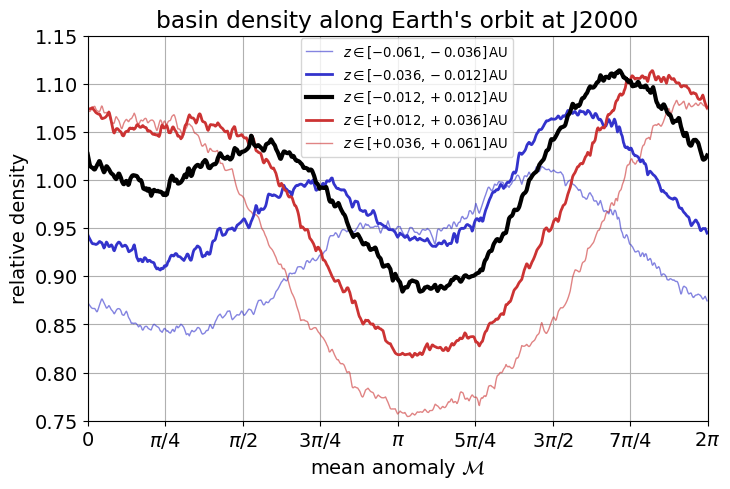

In [209]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(M_sample,dens_sample_m2/np.mean(dens_sample),lw=1,color=(0.2,0.2,0.8,0.6),label=r'$z \in [-0.061,-0.036]\,\mathrm{AU}$');
ax.plot(M_sample,dens_sample_p2/np.mean(dens_sample),lw=1,color=(0.8,0.2,0.2,0.6),label=r'$z \in [+0.036,+0.061]\,\mathrm{AU}$');
ax.plot(M_sample,dens_sample_m/np.mean(dens_sample),lw=2,color=(0.2,0.2,0.8,1),label=r'$z \in [-0.036,-0.012]\,\mathrm{AU}$');
ax.plot(M_sample,dens_sample_p/np.mean(dens_sample),lw=2,color=(0.8,0.2,0.2,1),label=r'$z \in [+0.012,+0.036]\,\mathrm{AU}$');
ax.plot(M_sample,dens_sample/np.mean(dens_sample),color=(0,0,0,1),lw=3,label=r'$z \in [-0.012,+0.012]\,\mathrm{AU}$');
ax.set_xlim(0,2*np.pi);
ax.set_xticks(np.arange(0,2*np.pi+1e-10,np.pi/4))
ax.set_xticklabels([0,'$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$','$5\pi/4$','$3\pi/2$','$7\pi/4$','$2\pi$'])
ax.set_xlabel(r'mean anomaly $\mathcal{M}$')
ax.set_ylabel('relative density')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0,2,4,3,1]
#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=9.5,loc='upper center', bbox_to_anchor=(0.515,1.01))
ax.set_ylim(0.75,1.15);
ax.set_title(r"basin density along Earth's orbit at J2000")
ax.grid(); 

### DFT analysis

In [210]:
dens_sample_fft = np.fft.rfft(dens_sample)
dens_sample_freq = np.fft.rfftfreq(n_sample,1/n_sample)

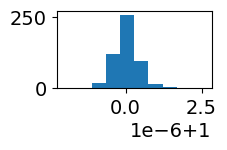

In [211]:
fig,ax=plt.subplots(1,1,figsize=(2,1))
ax.hist(np.real(dens_sample_fft/np.sum(dens_sample_fft_strap,axis=0))); #these must be very close to 1

In [146]:
res_fft_real = np.zeros((len(dens_sample_freq),5)); #mean, lo 68, hi 68, lo 95, hi 95
res_fft_imag = np.zeros((len(dens_sample_freq),5)); #mean, lo 68, hi 68, lo 95, hi 95
for i in tqdm(range(len(dens_sample_freq))):
    data = np.real(dens_sample_fft_strap[:,i])
    mean = np.mean(data)
    res1 = stats.bootstrap((data,),np.mean,confidence_level=0.68,n_resamples=int(1e4))
    res2 = stats.bootstrap((data,),np.mean,confidence_level=0.95,n_resamples=int(1e4))
    res_fft_real[i] = [mean,res1.confidence_interval[0],res1.confidence_interval[1],res2.confidence_interval[0],res2.confidence_interval[1]]
    data = np.imag(dens_sample_fft_strap[:,i])
    mean = np.mean(data)
    res1 = stats.bootstrap((data,),np.mean,confidence_level=0.68,n_resamples=int(1e4))
    res2 = stats.bootstrap((data,),np.mean,confidence_level=0.95,n_resamples=int(1e4))
    res_fft_imag[i] = [mean,res1.confidence_interval[0],res1.confidence_interval[1],res2.confidence_interval[0],res2.confidence_interval[1]]

  0%|          | 0/513 [00:00<?, ?it/s]/Users/kvantilburg/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in true_divide
  a_hat = num / den
/Users/kvantilburg/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
100%|██████████| 513/513 [01:18<00:00,  6.50it/s]


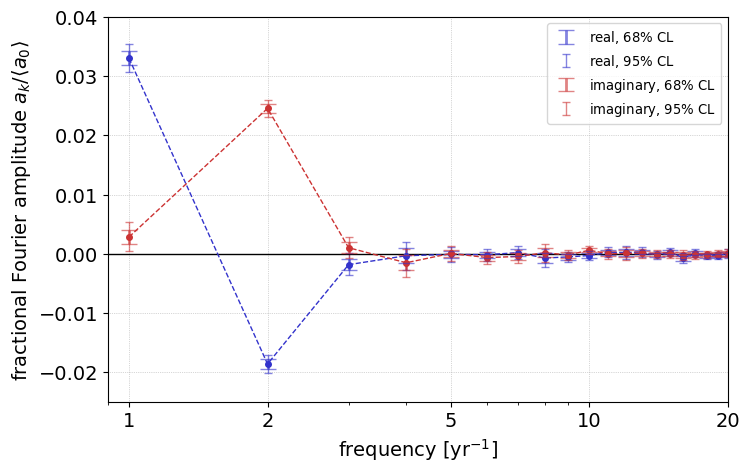

In [213]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.axhline(0,color=(0,0,0),lw=1)
ax.plot(dens_sample_freq[1:],res_fft_real[1:,0]/res_fft_real[0,0],color=(0.2,0.2,0.8),marker='.',ms=8,lw=1,ls='dashed')
ax.plot(dens_sample_freq[1:],res_fft_imag[1:,0]/res_fft_real[0,0],color=(0.8,0.2,0.2),marker='.',ms=8,lw=1,ls='dashed')
ax.errorbar(dens_sample_freq[1:],res_fft_real[1:,0]/res_fft_real[0,0],
            yerr=[np.abs((res_fft_real[1:,3]-res_fft_real[1:,0])/res_fft_real[0,0]),np.abs((res_fft_real[1:,4]-res_fft_real[1:,0])/res_fft_real[0,0])],
           color=(0.2,0.2,0.8,0.6),capsize=3,label=r'real, $95\%$ CL',lw=0,elinewidth=1)
ax.errorbar(dens_sample_freq[1:],res_fft_real[1:,0]/res_fft_real[0,0],
            yerr=[np.abs((res_fft_real[1:,1]-res_fft_real[1:,0])/res_fft_real[0,0]),np.abs((res_fft_real[1:,2]-res_fft_real[1:,0])/res_fft_real[0,0])],
           color=(0.2,0.2,0.8,0.6),capsize=6,label=r'real, $68\%$ CL',lw=0,elinewidth=2)
ax.errorbar(dens_sample_freq[1:],res_fft_imag[1:,0]/res_fft_real[0,0],
            yerr=[np.abs((res_fft_real[1:,3]-res_fft_real[1:,0])/res_fft_real[0,0]),np.abs((res_fft_real[1:,4]-res_fft_real[1:,0])/res_fft_real[0,0])],
           color=(0.8,0.2,0.2,0.6),capsize=3,label=r'imaginary, $95\%$ CL',lw=0,elinewidth=1)
ax.errorbar(dens_sample_freq[1:],res_fft_imag[1:,0]/res_fft_real[0,0],
            yerr=[np.abs((res_fft_real[1:,1]-res_fft_real[1:,0])/res_fft_real[0,0]),np.abs((res_fft_real[1:,2]-res_fft_real[1:,0])/res_fft_real[0,0])],
           color=(0.8,0.2,0.2,0.6),capsize=6,label=r'imaginary, $68\%$ CL',lw=0,elinewidth=2)
#ax.plot(dens_sample_freq[1:],res_fft_real[1:,0]/res_fft_real[0,0],color=(0.2,0.2,0.8,1),lw=0.5)
#ax.plot(dens_sample_freq[1:],res_fft_imag[1:,0]/res_fft_real[0,0],color=(0.8,0.2,0.2,1),lw=0.5)
#ax.fill_between(dens_sample_freq[1:],res_fft_real[1:,1]/res_fft_real[0,0],res_fft_real[1:,2]/res_fft_real[0,0])
ax.set_xscale('log');
ax.set_xlim(0.9,20)
ax.set_ylim(-0.025,0.04);
ax.set_xticks([1,2,5,10,20])
ax.set_xticklabels([1,2,5,10,20])
ax.grid(lw=0.5,ls='dotted'); ax.legend();
ax.set_xlabel(r'frequency $[\mathrm{yr}^{-1}]$');
ax.set_ylabel(r'fractional Fourier amplitude $a_k / \langle a_0 \rangle$');
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [1,0,3,2]
#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=9.5,loc='upper right');

### Real-space variation + best-fit

In [247]:
res_fft_real.shape

(513, 5)

In [231]:
res_real = np.zeros((dens_sample_strap.shape[1],5)); #mean, lo 68, hi 68, lo 95, hi 95

In [232]:
for i in tqdm(range(dens_sample_strap.shape[1])):
    data = np.real(dens_sample_strap[:,i])
    mean = np.mean(data)
    res1 = stats.bootstrap((data,),np.mean,confidence_level=0.68,n_resamples=int(1e3))
    res2 = stats.bootstrap((data,),np.mean,confidence_level=0.95,n_resamples=int(1e3))
    res_real[i] = [mean,res1.confidence_interval[0],res1.confidence_interval[1],res2.confidence_interval[0],res2.confidence_interval[1]]

100%|██████████| 1024/1024 [00:11<00:00, 90.31it/s]


In [250]:
M_sample

array([0.00000000e+00, 6.13592315e-03, 1.22718463e-02, ...,
       6.26477754e+00, 6.27091346e+00, 6.27704938e+00])

In [253]:
np.conjugate(1+2j)

(1-2j)

In [257]:
dens_fit = (res_fft_real[1,0]+1j*res_fft_imag[1,0])/res_fft_real[0,0]*(np.exp(1j*M_sample)) + (res_fft_real[2,0]+1j*res_fft_imag[2,0])/res_fft_real[0,0]*(np.exp(2j*M_sample))
dens_fit = np.real(1 + dens_fit + np.conjugate(dens_fit))
dens_fit

array([1.02882139, 1.02818576, 1.02755334, ..., 1.03074663, 1.03010192,
       1.02946014])

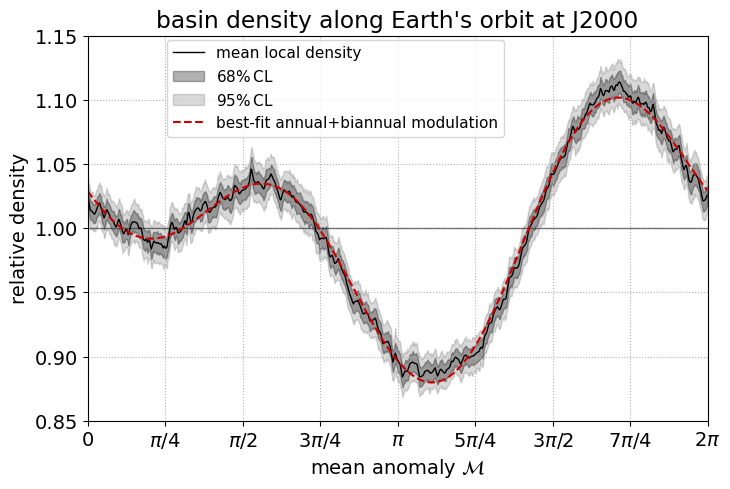

In [277]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.axhline(1,color=(0,0,0,0.5),lw=1)
ax.plot(M_sample,res_real[:,0]/np.mean(res_real[:,0]),color=(0,0,0,1),lw=1,label='mean local density')
ax.fill_between(M_sample,res_real[:,1]/np.mean(res_real[:,0]),res_real[:,2]/np.mean(res_real[:,0]),
                color=(0,0,0,0.3),label='$68\%\,\mathrm{CL}$')
ax.fill_between(M_sample,res_real[:,3]/np.mean(res_real[:,0]),res_real[:,4]/np.mean(res_real[:,0]),
                color=(0,0,0,0.15),label='$95\%\,\mathrm{CL}$')
ax.plot(M_sample,dens_fit,color=(0.8,0,0),ls='dashed',label='best-fit annual+biannual modulation')
ax.set_xlim(0,2*np.pi);
ax.set_xticks(np.arange(0,2*np.pi+1e-10,np.pi/4))
ax.set_xticklabels([0,'$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$','$5\pi/4$','$3\pi/2$','$7\pi/4$','$2\pi$'])
ax.set_xlabel(r'mean anomaly $\mathcal{M}$')
ax.set_ylabel('relative density')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0,2,3,1]
#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=11,loc='upper center', bbox_to_anchor=(0.4,1.01))
ax.set_ylim(0.85,1.15);
ax.set_title(r"basin density along Earth's orbit at J2000")
ax.grid(ls='dotted'); 

In [217]:
dens_sample_fft_strap.shape

(499, 513)

## Slice plot

In [662]:
list_slice_plot = np.arange(5,100,11); print(list_slice_plot)

[ 5 16 27 38 49 60 71 82 93]


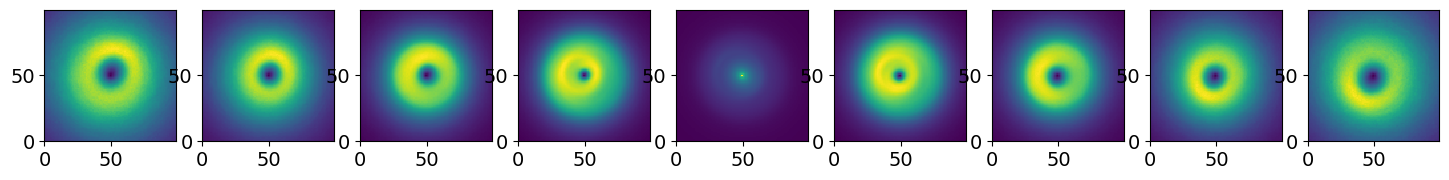

In [663]:
fig,ax = plt.subplots(1,9,figsize=(18,2))
for i in range(len(ax)):
    ax[i].pcolormesh(np.transpose(hist[:,:,list_slice_plot[i]]));
    ax[i].set_aspect(1)

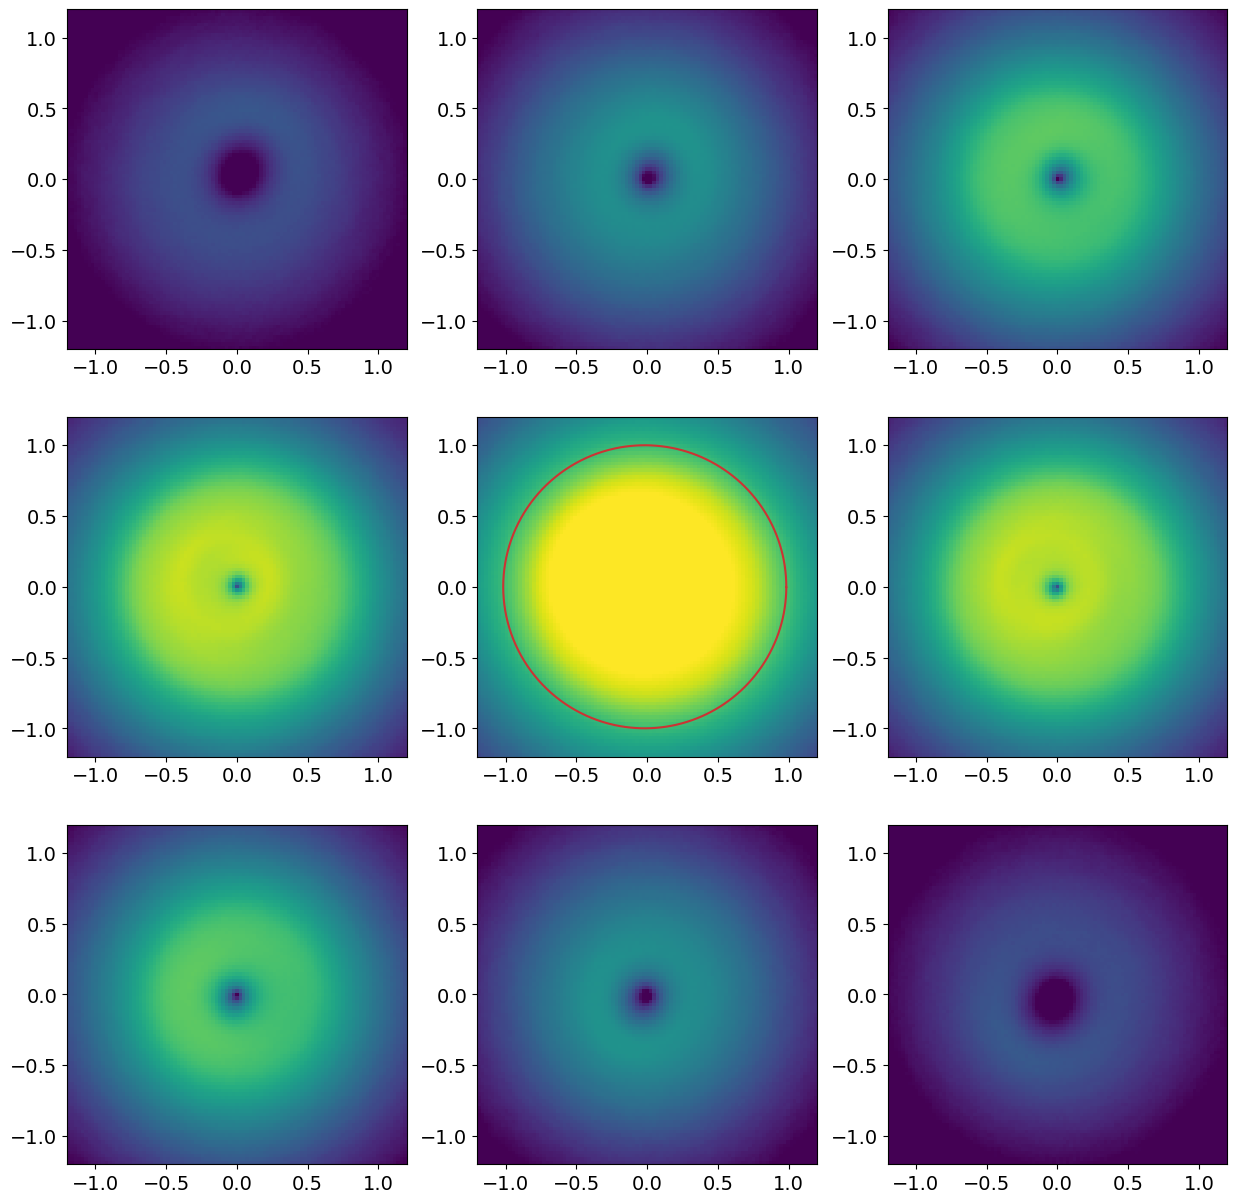

In [673]:
fig,ax = plt.subplots(3,3,figsize=(15,15))
for i in range(3):
    for j in range(3):
        ax[i,j].pcolormesh(bins_xy,bins_xy,np.transpose(hist[:,:,list_slice_plot[3*i+j]]),norm=mp.colors.LogNorm(vmin=3e4,vmax=2e6));
        ax[i,j].set_aspect(1)
ax[1,1].plot(pts_xy_Earth_orbit[0,:],pts_xy_Earth_orbit[1,:],color=(0.8,0.2,0.2));